# Imports

In [63]:
import json, requests, time
import torch
import numpy as np
import matplotlib.pyplot as plt

from diffusers import StableDiffusionXLPipeline
from transformers import BlipProcessor, BlipForConditionalGeneration

# Models load

## Stable Diffusion XL

In [49]:
STABLE_DIFF_PIPELINE = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, variant="fp16", use_safetensors=True
)

STABLE_DIFF_PIPELINE = STABLE_DIFF_PIPELINE.to("cuda")

Loading pipeline components...: 100%|██████████| 7/7 [00:10<00:00,  1.55s/it]


## BLIP

In [3]:
BLIP_PROCCESOR = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
BLIP_MODEL = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

# Caption generation using Blip

In [4]:
def generate_caption(img):
    inputs = BLIP_PROCCESOR(img, return_tensors="pt")

    out = BLIP_MODEL.generate(**inputs)
    return BLIP_PROCCESOR.decode(out[0], skip_special_tokens=True)

# Sentence similarity with DistilBERT

In [5]:
with open('info.json', 'r') as f:
    info = json.load(f)
api_token = info['api_token']

In [6]:
API_URL = "https://api-inference.huggingface.co/models/sentence-transformers/msmarco-distilbert-base-tas-b"
headers = {"Authorization": f"Bearer {api_token}"}

def query(payload):
    response = requests.post(API_URL, headers=headers, json=payload)
    return response.json()

In [7]:
def sentence_similarity(input_sentence, sentences):
    data = query(
        {
            "inputs": {
                "source_sentence": input_sentence,
                "sentences": sentences
            }
        })
    
    return data

# Generating original batch of images

In [39]:
prompt = "portrait of barbaric spanish conquistador, symmetrical, by yoichi hatakenaka, studio ghibli and dan mumford"
images = STABLE_DIFF_PIPELINE(prompt=prompt, num_images_per_prompt=5,
                             output_type='pil').images

100%|██████████| 50/50 [01:32<00:00,  1.85s/it]


# Calculate captions

In [40]:
captions = []
for i, img in enumerate(images):
    
    print("Processing image", i)
    caption = generate_caption(img)
    print("Generated caption:", caption)
    captions.append(caption)

Processing image 0
Generated caption: a drawing of a man in armor
Processing image 1
Generated caption: a drawing of a man with a helmet on
Processing image 2
Generated caption: a black and white drawing of a man in armor
Processing image 3
Generated caption: a drawing of a man with a beard and a hat
Processing image 4
Generated caption: a drawing of a man with a beard and a helmet


# Calculate similarities

In [70]:
similarities = dict()
while type(similarities) == dict:
    similarities = sentence_similarity(prompt, captions)
    if type(similarities) == dict:
        print('Waiting for availability: ', similarities['estimated_time'])
        time.sleep(similarities['estimated_time'])

# Show all results

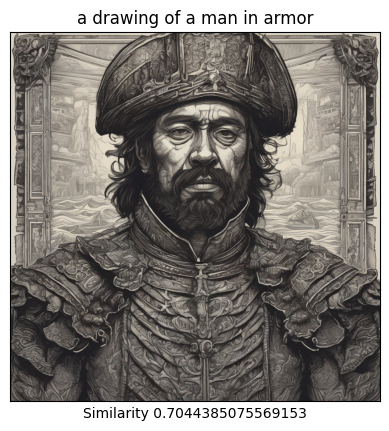

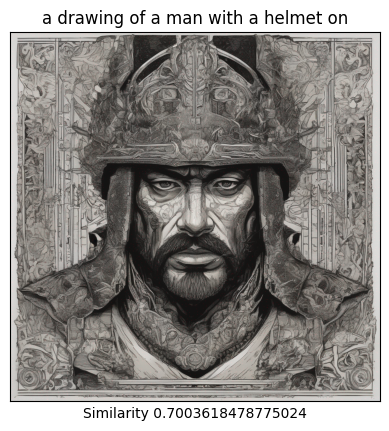

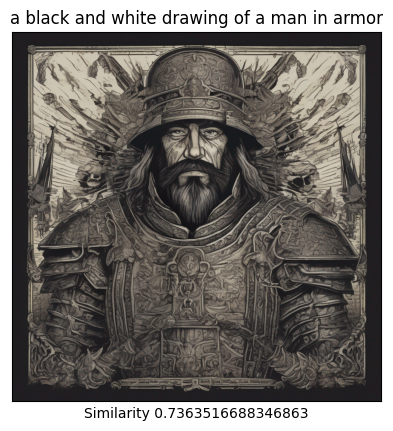

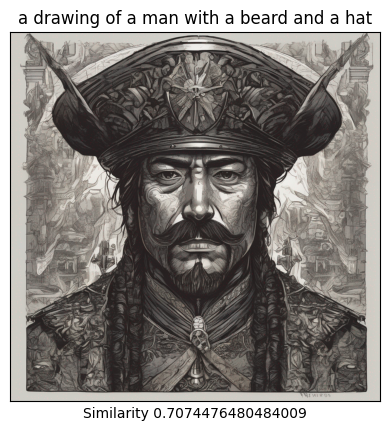

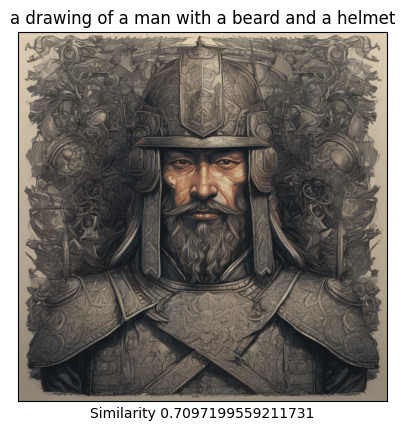

In [71]:
for img, caption, similarity in zip(images, captions, similarities):
    plt.imshow(img)
    plt.title(caption)
    plt.xlabel('Similarity ' + str(similarity))
    plt.xticks([])
    plt.yticks([])
    plt.show()